In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#map_dict = { "Extremely Positive": 0,"Positive": 1, "Neutral": 2, "Negative":3, "Extremely Negative":4} # Covid
map_dict = { "positive": 0, "neutral": 1, "negative":2} # US Airlines
#map_dict = { -1: 0, 0: 1, 1: 2} # SemEval Sentiment Analysis
num_class = 3

In [3]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.3 MB/s eta 0:00:00


In [4]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

In [5]:
train = pd.read_csv('/content/drive/MyDrive/train_encoded.csv', encoding='latin-1').values
y_train = pd.read_csv('/content/drive/MyDrive/train_sentiment.csv', encoding='latin-1')['Sentiment']
y_train = y_train.map(map_dict).values

# create validation test
train, validation, y_train, y_validation = train_test_split(train, y_train, test_size=0.2, shuffle=True, stratify = y_train)
y_train_true = y_train
y_validation_true = y_validation

test = pd.read_csv('/content/drive/MyDrive/test_encoded.csv', encoding='latin-1').values
y_test = pd.read_csv('/content/drive/MyDrive/test_sentiment.csv', encoding='latin-1')['Sentiment']
y_test = y_test.map(map_dict).values
y_test_true = y_test

In [6]:
#from sklearn.utils import resample
#train, y_train = resample(train, y_train , n_samples=3000, replace=False, stratify=y_train, random_state=0)

In [7]:
def y_one_hot(y):
  onehot_encoder = OneHotEncoder(sparse=False)
  y_onehot = y.reshape(len(y), 1)
  y_onehot = onehot_encoder.fit_transform(y_onehot)
  return y_onehot

In [8]:
y_train_onehot = y_one_hot(y_train)
y_validation_onehot = y_one_hot(y_validation)
y_test_onehot = y_one_hot(y_test)

**Distributed training**

In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tqdm import tqdm
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [10]:
batch_size = 128

train = tf.data.Dataset.from_tensor_slices(train).batch(batch_size=batch_size)
test = tf.data.Dataset.from_tensor_slices(test).batch(batch_size=batch_size)
validation = tf.data.Dataset.from_tensor_slices(validation).batch(batch_size=batch_size)

y_train = tf.data.Dataset.from_tensor_slices(y_train_onehot).batch(batch_size=batch_size)
y_test = tf.data.Dataset.from_tensor_slices(y_test_onehot).batch(batch_size=batch_size)
y_validation = tf.data.Dataset.from_tensor_slices(y_validation_onehot).batch(batch_size=batch_size)

In [11]:
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)

  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  
  return logits, loss_value

In [12]:
def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for (x,y) in zip(enumerate(train), enumerate(y_train)):
      step, x_batch_train = x
      _, y_batch_train = y
      logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)     
      losses.append(loss_value)
      train_acc_metric(y_batch_train, logits)
      pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
      pbar.update()
  return losses


In [14]:
def define_ground_cost(n):
    
    M = np.zeros([n,n])
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            M[i,j] = abs(j- i)

    M = tf.convert_to_tensor(M)
    return M / tf.reduce_sum(M) 

define_ground_cost(num_class)

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[0.   , 0.125, 0.25 ],
       [0.125, 0.   , 0.125],
       [0.25 , 0.125, 0.   ]])>

In [44]:
def loss_function(y_true, y_pred):

  #optimal transport
  M = define_ground_cost(num_class)
  M = tf.convert_to_tensor(M)
  reverse_y_true = 1 -y_true
  elements = tf.math.multiply_no_nan(x=y_pred, y=reverse_y_true.astype(np.float32))
  cost = M[tf.math.argmax(y_true, axis =1)]
  elements = tf.math.multiply_no_nan(x=elements, y = cost.astype(np.float32))
  
  #regularization
  labda = 0.0001
  regularization_elements =  tf.math.multiply_no_nan(x=y_pred, y=tf.math.log(y_pred))
  
  return tf.reduce_mean(tf.reduce_sum(elements,axis=1)) + labda * tf.reduce_mean(tf.reduce_sum(regularization_elements,axis=1))

In [49]:
vocab_size = 10000
max_length = 39
embedding_dim = 100
oov_tok = "<OOV>"

#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1000000, decay_rate=0.9)
#clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=0.0001, maximal_learning_rate=0.01,
#    scale_fn=lambda x: 1/(2.**(x-1)), step_size=2 * 100)
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()

#loss_object = tf.keras.losses.CategoricalCrossentropy()
loss_object = loss_function

def build_model():

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(num_class, activation='softmax')
    ])
    model.compile(optimizer, loss=loss_object, metrics= train_acc_metric)
    
    return model

model = build_model()

In [50]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 39, 100)           1000000   
                                                                 
 global_average_pooling1d_6   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 512)               51712     
                                                                 
 dense_13 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 1,053,251
Trainable params: 1,053,251
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Iterate over epochs.
epochs = 5
epochs_val_acc, epochs_train_acc = [], []
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch+1,))
  
  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  epochs_train_losses.append(losses_train_mean)

  print('Epoch %s: Train loss: %.4f, Train Accuracy: %.4f' % (epoch+1, float(losses_train_mean), float(train_acc)*100))
  
  epochs_train_acc.append(float(train_acc)*100)
  y_pred_val = np.argmax(model.predict(validation),axis=1)
  val_acc = (y_validation_true == y_pred_val).sum() / len(y_validation_true)
  epochs_val_acc.append(float(val_acc)*100)

  print('Validation Accuracy: %.4f \n' % (float(val_acc)*100))

  train_acc_metric.reset_states()

Start of epoch 1


Training loss for step 73: 0.0547: 100%|██████████| 74/74 

Epoch 1: Train loss: 0.0664, Train Accuracy: 62.8098
19/19 [==============================] - 0s 4ms/step


Validation Accuracy: 62.7082 

Start of epoch 2


Training loss for step 69: 0.0403:  95%|█████████▍| 70/74 
Training loss for step 73: 0.0547: 100%|██████████| 74/74 

Epoch 2: Train loss: 0.0663, Train Accuracy: 62.8419
19/19 [==============================] - 0s 7ms/step


Validation Accuracy: 62.7510 

Start of epoch 3


Training loss for step 73: 0.0555: 100%|██████████| 74/74 

Epoch 3: Train loss: 0.0661, Train Accuracy: 62.9274
19/19 [==============================] - 0s 4ms/step


Validation Accuracy: 62.7937 

Start of epoch 4


Training loss for step 73: 0.0528: 100%|██████████| 74/74 

Epoch 4: Train loss: 0.0526, Train Accuracy: 66.8483
19/19 [==============================] - 0s 5ms/step


Validation Accuracy: 68.4750 

Start of epoch 5


Training loss for step 73: 0.0328: 100%|██████████| 74/74 

Epoch 5: Train loss: 0.0370, Train Accuracy: 74.7009
19/19 [==============================] - 0s 5ms/step
Validation Accuracy: 75.5233 



In [55]:
model.predict(test)

23/23 [==============================] - 0s 4ms/step


array([[2.2607321e-05, 3.4929824e-03, 9.9648446e-01],
       [5.4340249e-01, 4.5609549e-01, 5.0202163e-04],
       [5.8261955e-01, 4.1717991e-01, 2.0048300e-04],
       ...,
       [1.7687557e-02, 7.6123184e-01, 2.2108065e-01],
       [2.3812839e-07, 5.0158535e-05, 9.9994951e-01],
       [3.9826944e-08, 1.4386797e-05, 9.9998558e-01]], dtype=float32)

In [56]:
# prediction
y_pred_test = model.predict(test)
y_pred_test = np.argmax(y_pred_test,axis=1) 

#for i in range(0,len(y_test_true)):
#  if y_test_true[i] == 0:
#    y_test_true[i] = 1
#  if y_test_true[i] == 4:
#    y_test_true[i] = 3

m = confusion_matrix(y_test_true,y_pred_test)
print('Tacnost na test podacima: ')
print(sum(m[i][i] for i in range(len(m))) / sum(sum(m))*100)
print('Konfuziona matrica na test podacima: ')
print(m)

23/23 [==============================] - 0s 4ms/step
Tacnost na test podacima: 
73.87880862718247
Konfuziona matrica na test podacima: 
[[ 241  162   69]
 [  64  312  241]
 [  13  214 1605]]


Text(0.5, 1.0, 'Accuracu')

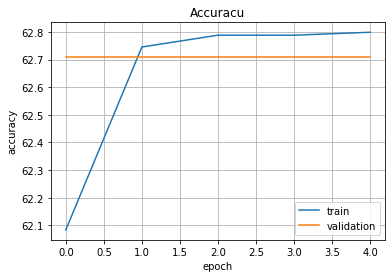

In [42]:
plt.plot(epochs_train_acc)
plt.plot(epochs_val_acc)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
plt.title('Accuracu')

In [58]:
print(classification_report(y_test_true,y_pred_test))

              precision    recall  f1-score   support

           0       0.76      0.51      0.61       472
           1       0.45      0.51      0.48       617
           2       0.84      0.88      0.86      1832

    accuracy                           0.74      2921
   macro avg       0.68      0.63      0.65      2921
weighted avg       0.74      0.74      0.74      2921

